## Starbucks Capstone Challenge

### Data Sets

* portfolio.json: contiene ID de oferta y metadatos sobre cada oferta (duración, tipo, etc.)
* profile.json - datos demográficos de cada cliente
* transcript.json: registros de transacciones, ofertas recibidas, ofertas vistas y ofertas completadas


Preguntas guía:

1. ¿Las personas reaccionan de manera diferente a las diferentes promociones?
    - En caso afirmativo, ¿cómo reacciona la gente a las diferentes promociones?
2. ¿Cuáles son los factores que afectan estas reacciones?

Preguntas soporte

* ¿Cuál es la distribución de género de los clientes de Starbucks?
* ¿Cuál es la distribución por edad de los clientes de Starbucks?
* ¿Cuál es la distribución de ingresos de los clientes de Starbucks?
* ¿Cuántos clientes se inscribieron anualmente?
* ¿Qué género tiene la membresía anual más alta?
* ¿Qué género tiene el ingreso anual más alto?
* ¿Cuál es la distribución de eventos en las transcripciones?
* ¿Cuál es el porcentaje de transacciones y ofertas en el evento?
* ¿Cuál es la Distribución de Ingresos para los Eventos de la Oferta?
* ¿Cuáles son los tipos de Oferta entre edades, sexos y grupos de ingresos?

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error

from sklearn import preprocessing
from sklearn import cluster
from sklearn.cluster import KMeans

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Preparing:

## portfolio.json:

* portfolio dataset contains 10 records and 6 columns.  

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
print('minimum duration: ', portfolio.duration.min())
print('maximun duration: ',portfolio.duration.max())

minimum duration:  3
maximun duration:  10


In [7]:
print('mean reward value: ', portfolio.reward.mean())
print('median reward value: ',portfolio.reward.median())

mean reward value:  4.2
median reward value:  4.0


In [8]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [9]:
portfolio.offer_type.describe()

count       10
unique       3
top       bogo
freq         4
Name: offer_type, dtype: object

In [10]:
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [11]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [12]:
portfolio.reward.value_counts()

5     3
10    2
0     2
2     2
3     1
Name: reward, dtype: int64

In [13]:
portfolio.duration.value_counts()

7     4
5     2
10    2
4     1
3     1
Name: duration, dtype: int64

In [14]:
portfolio.difficulty.value_counts()

10    4
0     2
5     2
20    1
7     1
Name: difficulty, dtype: int64

In [15]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [16]:
sum(portfolio.duplicated('id'))

0

In [17]:
print(portfolio.offer_type.nunique())
print(portfolio.offer_type.unique())

3
['bogo' 'informational' 'discount']


In [18]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [19]:
portfolio[['offer_type', 'difficulty', 'duration', 'reward']]

,offer_type,difficulty,duration,reward
0,bogo,10,7,10
1,bogo,10,5,10
2,informational,0,4,0
3,bogo,5,7,5
4,discount,20,10,5
5,discount,7,7,3
6,discount,10,10,2
7,informational,0,3,0
8,bogo,5,5,5
9,discount,10,7,2


In [20]:
for ele in range(portfolio.shape[0]):
    row = portfolio.iloc[ele]
    print(" offer-{}:-- {}:difficulty, {}:duration, {}:reward ".format(row['offer_type'], row['difficulty'], row['duration'], row['reward']))

 offer-bogo:-- 10:difficulty, 7:duration, 10:reward 
 offer-bogo:-- 10:difficulty, 5:duration, 10:reward 
 offer-informational:-- 0:difficulty, 4:duration, 0:reward 
 offer-bogo:-- 5:difficulty, 7:duration, 5:reward 
 offer-discount:-- 20:difficulty, 10:duration, 5:reward 
 offer-discount:-- 7:difficulty, 7:duration, 3:reward 
 offer-discount:-- 10:difficulty, 10:duration, 2:reward 
 offer-informational:-- 0:difficulty, 3:duration, 0:reward 
 offer-bogo:-- 5:difficulty, 5:duration, 5:reward 
 offer-discount:-- 10:difficulty, 7:duration, 2:reward 


## profile.json:

* profile dataset contains 17000 records and 5 columns.

In [21]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [22]:
profile.shape

(17000, 5)

In [23]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [24]:
print('mean income value: ', profile.income.mean())
print('median income value: ', profile.income.median())

mean income value:  65404.9915682968
median income value:  64000.0


In [25]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [26]:
profile.describe(include = 'object')

,gender,id
count,14825,17000
unique,3,17000
top,M,68be06ca386d4c31939f3a4f0e3dd783
freq,8484,1


In [27]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [28]:
profile.sample(5)

,gender,age,id,became_member_on,income
3995,M,54,822415f7e4874367af290069124672e3,20180420,59000.0
7074,M,41,ce92049bad964839982c973c5013fbb8,20170724,31000.0
1652,F,77,84df7379c5ef440c95487180a6901ee6,20180211,63000.0
7997,None,118,631b3ebd660243df8069c49d4c37f836,20160411,NaN
9764,F,75,386feea26f434f559cb91d02679c4c3a,20160628,49000.0


In [29]:
sum(profile.duplicated())

0

In [30]:
sum(profile.id.duplicated())

0

In [31]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [32]:
profile.became_member_on.nunique()

1716

In [33]:
profile.age.nunique()

85

In [34]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99], dtype=int64)

In [35]:
age_118 = profile[profile.age == 118].count()
age_118

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [36]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [37]:
profile.groupby('gender')['age'].count()

gender
F    6129
M    8484
O     212
Name: age, dtype: int64

In [38]:
profile.groupby('gender')['age'].mean()

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64

In [39]:
profile.groupby('gender')['income'].mean()

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64

In [40]:
profile.age.mean()

62.53141176470588

In [41]:
profile.income.mean()

65404.9915682968

In [42]:
profile.id.nunique()

17000

## transcript.json:

* transcript dataset contains 306534 records and 4 columns.

In [43]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [44]:
transcript.shape

(306534, 4)

In [45]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [46]:
print('mean time value: ', transcript.time.mean())
print('median time value: ',transcript.time.median())

mean time value:  366.382939576034
median time value:  408.0


In [47]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [48]:
transcript.describe(include = 'object')

,person,event,value
count,306534,306534,306534
unique,17000,4,5121
top,94de646f7b6041228ca7dec82adb97d2,transaction,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,51,138953,14983


In [49]:
transcript.sample(5)

,person,event,value,time
83178,c61e90bc54de43a1888f229d46d62daf,transaction,{'amount': 0.37},204
227275,684644265732451ba78dbcb6b639c1c6,transaction,{'amount': 1.51},522
70937,8a0b4d0294d4466eb708bd52a6852821,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},174
29414,6676062b996d42499314026f12c2efac,transaction,{'amount': 19.89},42
118065,7106e78bb41f4e5fab74c2c9cf1e459f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},336


In [50]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [51]:
sum(transcript.person.duplicated())

289534

In [52]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [53]:
transcript.event.nunique()

4

In [54]:
transcript.value.head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [55]:
transcript.person.nunique()

17000

In [56]:
received = transcript.query(" event == 'offer received' ")['time'].mean()
completed = transcript.query(" event == 'offer completed' ")['time'].mean()
viewed = transcript.query(" event == 'offer viewed' ")['time'].mean()
transactions = transcript.query(" event == 'transaction' ")['time'].mean()

print('mean time of offer received:', received)
print('mean time of offer viewed:', viewed)
print('mean time of offer completed:', completed)
print('mean time of transactions:', transactions)

mean time of offer received: 332.57951938330035
mean time of offer viewed: 354.29051537462107
mean time of offer completed: 401.0528008576789
mean time of transactions: 381.58433427130035


In [57]:
received = transcript.query(" event == 'offer received' ")['time'].count()
completed = transcript.query(" event == 'offer completed' ")['time'].count()
viewed = transcript.query(" event == 'offer viewed' ")['time'].count()
transactions = transcript.query(" event == 'transaction' ")['time'].count()

print('offer received counts:', received)
print('offer viewed counts:', viewed)
print('offer completed counts:', completed)
print('transactions counts:', transactions)

offer received counts: 76277
offer viewed counts: 57725
offer completed counts: 33579
transactions counts: 138953


In [58]:
transcript.time.nunique()

120

In [59]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714], dtype=int64)

In [60]:
transcript.query(" event == 'transaction' ")

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [61]:
transcript.query(" event == 'offer completed' ")

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0
...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714


# Data Pre-processing:

## pre processing portfolio dataset:

- cambiar nombre de id column
- one hot encoding sobre Channel column

In [62]:
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

In [63]:
# One-hot encode : channels column:

portfolio['email'] = portfolio['channels'].apply(lambda ele: 1 if 'email' in ele else 0)
portfolio['web'] = portfolio['channels'].apply(lambda ele: 1 if 'web' in ele else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda ele: 1 if 'mobile' in ele else 0)
portfolio['social'] = portfolio['channels'].apply(lambda ele: 1 if 'social' in ele else 0)

In [64]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   offer_id    10 non-null     object
 6   email       10 non-null     int64 
 7   web         10 non-null     int64 
 8   mobile      10 non-null     int64 
 9   social      10 non-null     int64 
dtypes: int64(7), object(3)
memory usage: 928.0+ bytes


In [65]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id,email,web,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


## Exploratory Data Analysis for portfolio dataset:

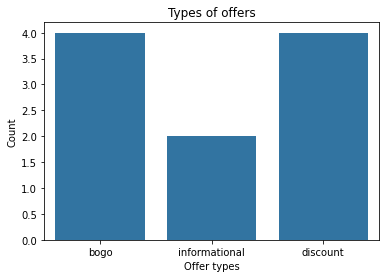

In [66]:
# types of offers:

color = sb.color_palette()[0]

sb.countplot(data = portfolio, x = 'offer_type', color = color);
plt.title('Types of offers');
plt.ylabel('Count');
plt.xlabel('Offer types');

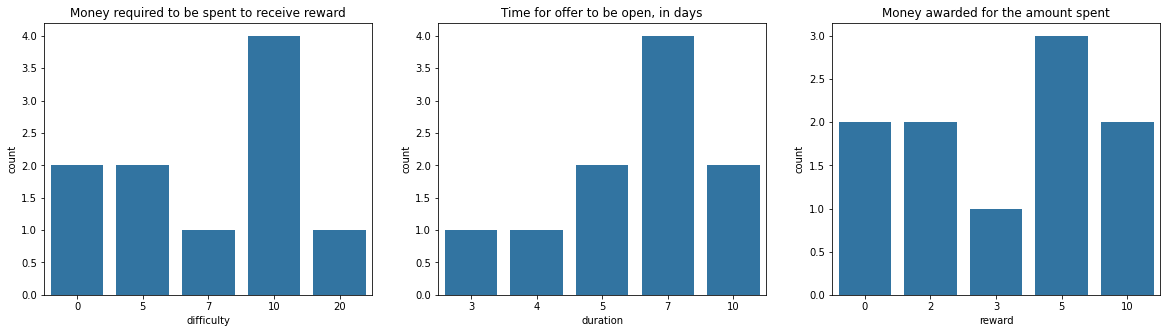

In [67]:
# Creating Subplots for distribution based on difficulty, duration, reward for portfolio data.

plt.figure(figsize = [20,5])

color = sb.color_palette()[0]
plt.subplot(1,3,1)

sb.countplot(data = portfolio, x = 'difficulty', color = color);
plt.title('Money required to be spent to receive reward');
plt.ylabel('count');
plt.xlabel('difficulty');

plt.subplot(1,3,2)
sb.countplot(data = portfolio, x = 'duration', color = color);
plt.title('Time for offer to be open, in days');
plt.ylabel('count');
plt.xlabel('duration');

plt.subplot(1,3,3)
sb.countplot(data = portfolio, x = 'reward', color = color);
plt.title('Money awarded for the amount spent');
plt.ylabel('count');
plt.xlabel('reward');

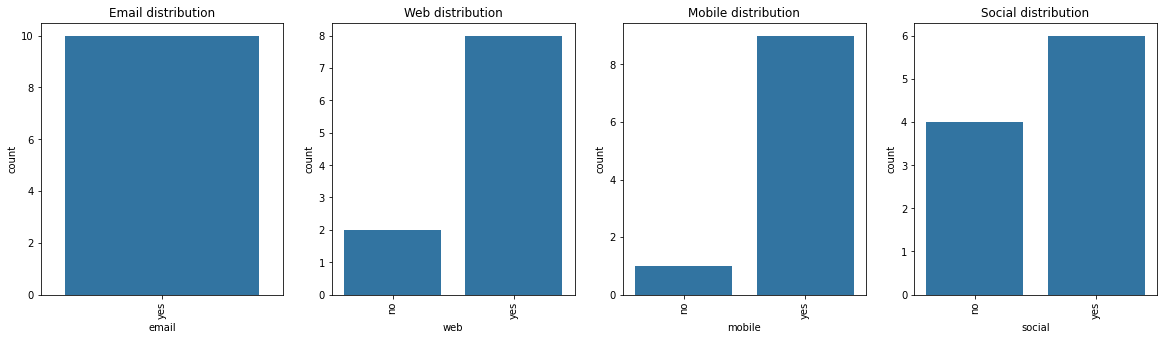

In [68]:
# Creating Subplots for distribution based on email, web, mobile and social for portfolio data.

plt.figure(figsize = [20,5])

color = sb.color_palette()[0]

plt.subplot(1,4,1)
x = sb.countplot(data = portfolio, x = 'email', color = color);
plt.title('Email distribution');
plt.ylabel('count');
plt.xlabel('email');
xlabels = ['yes']  #, 'no'
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,4,2)
x = sb.countplot(data = portfolio, x = 'web', color = color);
plt.title('Web distribution');
plt.ylabel('count');
plt.xlabel('web');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,4,3)
x = sb.countplot(data = portfolio, x = 'mobile', color = color);
plt.title('Mobile distribution');
plt.ylabel('count');
plt.xlabel('mobile');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,4,4)
x = sb.countplot(data = portfolio, x = 'social', color = color);
plt.title('Social distribution');
plt.ylabel('count');
plt.xlabel('social');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

## pre processing profile dataset:

* verifique la columna de edad para valores extremos (118)
* llenar con valores medios y cambiar su tipo de datos
* cambie el nombre de las columnas de identificación para facilitar la comprensión
* crear una nueva columna agrupada con grupo de edad
* crear nueva columna agrupada con grupo salarial
* crear un formato de fecha legible en la columna Become_member_on
* extraer su año, mes y día de la columna Become_member_on agregar a las columnas (para un análisis más detallado)




* crear una nueva columna agrupada con el grupo member_since

In [69]:
profile['age'] = profile['age'].apply(lambda ele: 0 if ele == 118 else ele)

In [70]:
profile['income'].fillna((profile['income'].median()), inplace=True)

In [71]:
profile.rename(columns = {'id': 'customer_id'}, inplace = True)

In [72]:
def Ages(ele):
        if ele < 20:
            return 1
        elif 21 < ele <= 30:
            return 2
        elif 31 <= ele <= 40:
            return 3
        elif 41 <= ele <= 50:
            return 4
        elif 51 <= ele <= 60:
            return 5
        elif 61 <= ele <= 70:
            return 6
        elif 71 <= ele <= 80:
            return 7
        elif 81 <= ele <= 90:
            return 8
        elif 91 <= ele <= 101:
            return 9
        else:
            return 10
            
profile['age_groups'] = profile['age'].apply(Ages)

In [73]:
def Salarys(ele):
        if ele < 30000:
            return 1
        elif 30001 < ele <= 40000:
            return 2
        elif 40001 <= ele <= 50000:
            return 3
        elif 50001 <= ele <= 60000:
            return 4
        elif 60001 <= ele <= 70000:
            return 5
        elif 70001 <= ele <= 80000:
            return 6
        elif 80001 <= ele <= 90000:
            return 7
        elif 90001 <= ele <= 100000:
            return 8
        elif 100001 <= ele <= 110000:
            return 9
        elif 110001 <= ele <= 120000:
            return 10
        elif 120001 <= ele <= 150000:
            return 10
        else:
            return 0
            
profile['salary_groups'] = profile['income'].apply(Salarys)

In [74]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['member_year'] = profile['became_member_on'].dt.year
profile['member_month'] = profile['became_member_on'].dt.month
profile['member_day'] = profile['became_member_on'].dt.day

In [75]:
import datetime

profile['members_since_in_days'] = datetime.datetime.today().date() - profile['became_member_on'].dt.date
profile['members_since_in_days'] = profile['members_since_in_days'].dt.days

In [76]:
# create new column grouped with member_since group:

def Year(ele):
    if 744 <= ele <= 3*365:
        return 2
    elif 3*365 <= ele <= 4*365:
        return 3
    elif 4*365 <= ele <= 5*365:
        return 4
    elif 5*365 <= ele <= 6*365:
        return 5
    elif 6*365 <= ele <= 7*365:
        return 6
    elif 7*365 <= ele <= 8*365:
        return 7
    elif 8*365 <= ele <= 9*365:
        return 8
    else:
        return 0
            
profile['member_since_year'] = profile['members_since_in_days'].apply(Year)

In [77]:
profile.dropna(inplace = True)

In [78]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   gender                 14825 non-null  object        
 1   age                    14825 non-null  int64         
 2   customer_id            14825 non-null  object        
 3   became_member_on       14825 non-null  datetime64[ns]
 4   income                 14825 non-null  float64       
 5   age_groups             14825 non-null  int64         
 6   salary_groups          14825 non-null  int64         
 7   member_year            14825 non-null  int64         
 8   member_month           14825 non-null  int64         
 9   member_day             14825 non-null  int64         
 10  members_since_in_days  14825 non-null  int64         
 11  member_since_year      14825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(2)
memory

In [79]:
profile.head()

,gender,age,customer_id,became_member_on,income,age_groups,salary_groups,member_year,member_month,member_day,members_since_in_days,member_since_year
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,5,10,2017,7,15,1785,4
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,7,8,2017,5,9,1852,5
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,6,5,2018,4,26,1500,4
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,6,4,2018,2,9,1576,4
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,5,4,2017,11,11,1666,4


## Exploratory Data Analysis for profile dataset:

* ¿Cuál es la distribución de género de los clientes de Starbucks?
* ¿Cuál es la distribución por edad de los clientes de Starbucks?
* ¿Cuál es la distribución de ingresos de los clientes de Starbucks?

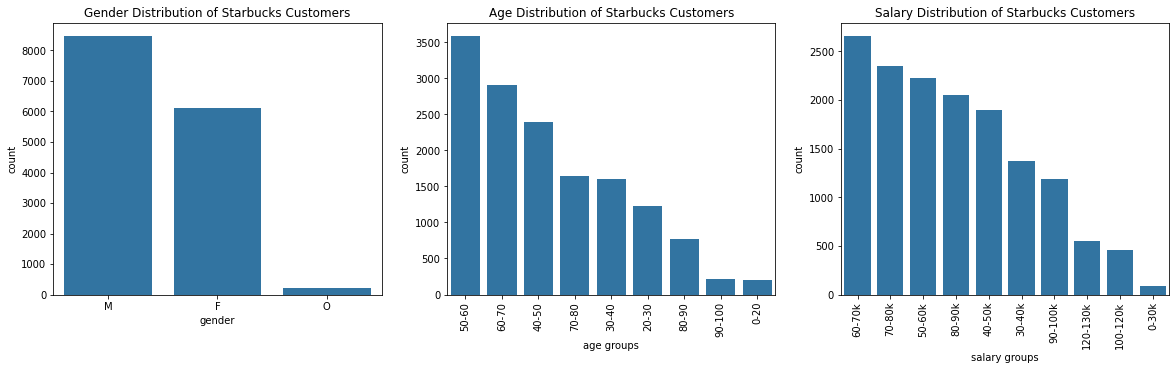

In [80]:
# Creating Subplots for distribution based on gender, age_groups, salary_groups for the cleaned Profile data:

plt.figure(figsize = [20,5])

color = sb.color_palette()[0]
plt.subplot(1,3,1)
order = ['M',  'F',  'O']
sb.countplot(data = profile, x = 'gender', color = color, order = order);
plt.title('Gender Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('gender');

plt.subplot(1,3,2)
order = [5, 6, 4, 7, 3, 2, 8, 9, 1]
x = sb.countplot(data = profile, x = 'age_groups', color = color, order = order);
plt.title('Age Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('age groups');
xlabels = ['50-60', '60-70', '40-50', '70-80', '30-40', '20-30', '80-90', '90-100', '0-20']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
order = [4, 5, 6, 2, 3, 7, 8, 9, 10, 0]
x = sb.countplot(data = profile, x = 'salary_groups', color = color, order = order);
plt.title('Salary Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('salary groups');
xlabels = ['60-70k', '70-80k', '50-60k', '80-90k', '40-50k', '30-40k', '90-100k', '120-130k', '100-120k', '0-30k']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

Según el gráfico,
1. La proporción de machos (alrededor de 9000) es ligeramente superior a la de hembras (alrededor de 6000) y muy pequeña a la de los demás.
2. El rango de edad de 40 a 70 años visita con frecuencia Starbucks.
3. Hay una disminución en el número de clientes a partir de 70K, mencionando que a medida que aumentan los ingresos, las personas gastan menos en café.

* ¿Cuántos clientes se inscribieron anualmente?

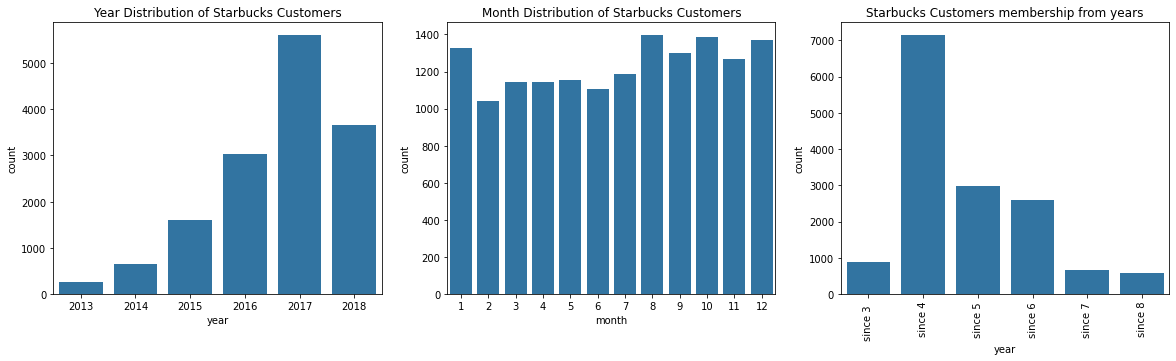

In [81]:
# Creating Subplots for distribution based on year, month, member_since for the cleaned Profile data:

plt.figure(figsize = [20,5])

color = sb.color_palette()[0]
plt.subplot(1,3,1)
sb.countplot(data = profile, x = 'member_year', color = color);
plt.title('Year Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('year');

plt.subplot(1,3,2)
sb.countplot(data = profile, x = 'member_month', color = color);
plt.title('Month Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('month');

plt.subplot(1,3,3)
x = sb.countplot(data = profile, x = 'member_since_year', color = color);
plt.title('Starbucks Customers membership from years');
plt.ylabel('count');
plt.xlabel('year');
xlabels = ['since 3 ', 'since 4', 'since 5', 'since 6', 'since 7', 'since 8']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

Según el gráfico, los miembros de Starbucks aumentaron exponencialmente desde 2013 y alcanzaron su punto más alto en 2017, que luego disminuyó de manera constante.

* ¿Qué género tiene la membresía anual más alta?

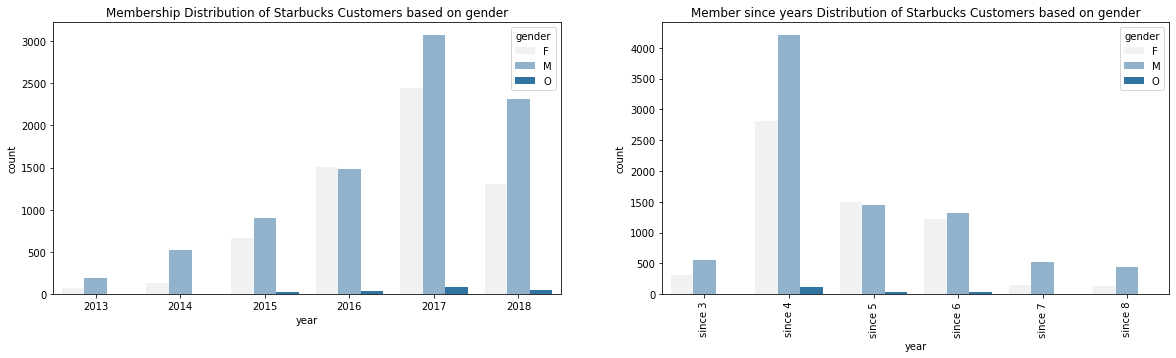

In [82]:
# Visualize distribution of membership years grouped by success:

plt.figure(figsize = [20,5])
color = sb.color_palette()[0]

plt.subplot(1,2,1)
sb.countplot(data = profile, x = 'member_year', hue = 'gender', color = color);
plt.title('Membership Distribution of Starbucks Customers based on gender');
plt.ylabel('count');
plt.xlabel('year');

plt.subplot(1,2,2)
x = sb.countplot(data = profile, x = 'member_since_year', hue = 'gender', color = color);
plt.title('Member since years Distribution of Starbucks Customers based on gender');
plt.ylabel('count');
plt.xlabel('year');
xlabels = ['since 3', 'since 4', 'since 5', 'since 6', 'since 7', 'since 8']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

Según el gráfico, con el aumento de la popularidad de Starbucks, las personas se unieron a Starbucks cada año de manera exponencial y alcanzaron su cenit en 2017.
Se han unido más hombres que mujeres y muy pocos de otros cada año.

* ¿Qué género tiene el ingreso anual más alto?

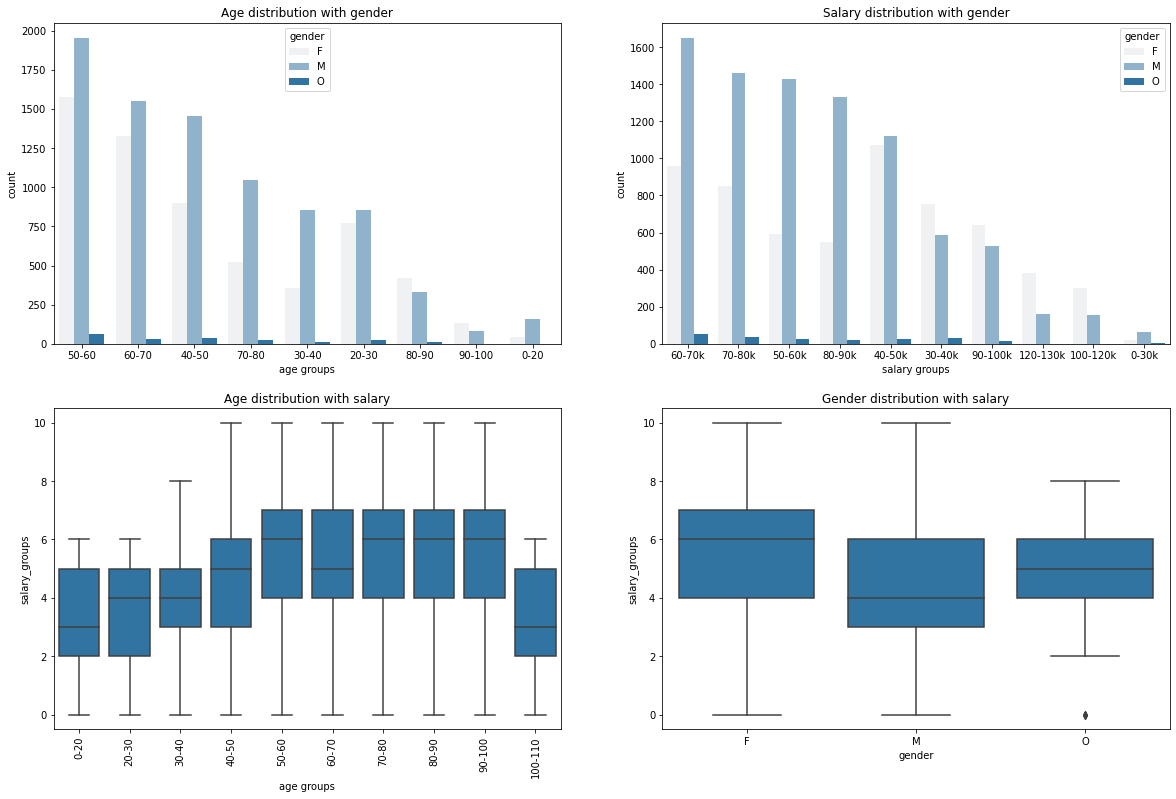

In [83]:
# Visualize distribution of age, salarys with gender:

plt.subplots(2, 2, figsize=(20, 13))
color = sb.color_palette()[0]


plt.subplot(2,2,1)
order = [5, 6, 4, 3, 2, 7, 8, 9, 1]
x = sb.countplot(data = profile, x = 'age_groups', order = order, hue = 'gender', color = color);
plt.title('Age distribution with gender');
plt.ylabel('count');
plt.xlabel('age groups');
xlabels = ['50-60', '60-70', '40-50', '70-80', '30-40', '20-30', '80-90', '90-100', '0-20']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(2,2,2)
order = [4, 5, 2, 3, 6, 7, 8, 9, 10, 0]
x = sb.countplot(data = profile, x = 'salary_groups', order = order, hue = 'gender', color = color);
plt.title('Salary distribution with gender');
plt.ylabel('count');
plt.xlabel('salary groups');
xlabels = ['60-70k', '70-80k', '50-60k', '80-90k', '40-50k', '30-40k', '90-100k', '120-130k', '100-120k', '0-30k']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

# Visualize distribution of age v/s salarys and salary v/s gender:

plt.subplot(2,2,3)
x = sb.boxplot(data = profile, x = 'age_groups', y = 'salary_groups', color = color);
plt.title('Age distribution with salary');
plt.ylabel('salary_groups');
plt.xlabel('age groups');
xlabels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(2,2,4)
sb.boxplot(data = profile, x = 'gender', y = 'salary_groups', color = color);
plt.title('Gender distribution with salary');
plt.ylabel('salary_groups');
plt.xlabel('gender');

Según el gráfico, los ingresos de las mujeres (alrededor de 70k) son más altos que los de los hombres y otros.

El recuento de clientes masculinos en el nivel de bajos ingresos es ligeramente superior al de mujeres y otros clientes

## pre processing transcript dataset:

* cambie el nombre de las columnas de identificación para facilitar la comprensión.
* Crear nuevas columnas offer_id, cantidad y recompensa de la columna de valor.
* Reemplace el valor nulo con 0 en la columna de cantidad.
* Eliminar columna value
* One hot encoding para la columna event.

In [84]:
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)

In [85]:
import ast

for ele in transcript['value']:
    try:
        ele['offer_id'] = ele.pop('offer id')
    except:
        pass

# Cree columnas separadas para cantidad y oferta_id y recompensa del diccionario de valor col:
data = pd.DataFrame([ast.literal_eval(json.dumps(ele)) for ele in transcript.value.values])
transcript = pd.concat([transcript, data], axis = 1)

In [86]:
transcript.amount = transcript.amount.replace({np.nan: 0})
transcript.drop('value', axis = 1, inplace = True)

In [87]:
df = pd.get_dummies(transcript['event'])

transcript = pd.concat([df, transcript], axis = 1, sort = False)

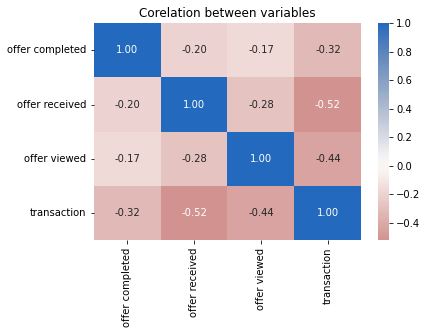

In [88]:
# Heatmap de correlaciones 
sb.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plt.title('Corelation between variables');

No hay relación entre los tipos de eventos. correlación negativa entre ellos.

In [89]:
transcript.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_recived', 
                             'offer viewed': 'offer_viewed'}, inplace = True)

In [90]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   offer_completed  306534 non-null  uint8  
 1   offer_recived    306534 non-null  uint8  
 2   offer_viewed     306534 non-null  uint8  
 3   transaction      306534 non-null  uint8  
 4   customer_id      306534 non-null  object 
 5   event            306534 non-null  object 
 6   time             306534 non-null  int64  
 7   offer_id         167581 non-null  object 
 8   amount           306534 non-null  float64
 9   reward           33579 non-null   float64
dtypes: float64(2), int64(1), object(3), uint8(4)
memory usage: 15.2+ MB


In [91]:
transcript.head()

,offer_completed,offer_recived,offer_viewed,transaction,customer_id,event,time,offer_id,amount,reward
0,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,NaN
1,0,1,0,0,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,NaN
2,0,1,0,0,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,NaN
3,0,1,0,0,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,NaN
4,0,1,0,0,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,NaN


## Exploratory Data Analysis for transcript dataset:

C:\Users\Oscar\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


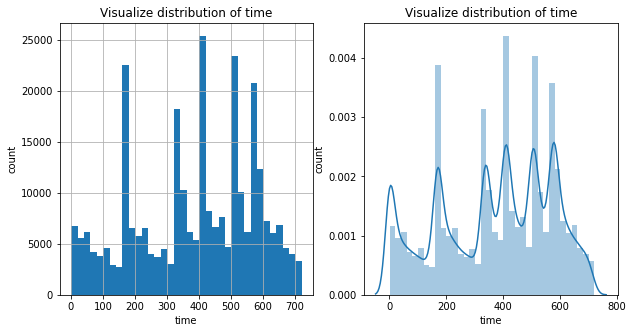

In [92]:
# Visualize distribution of time:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]
bins = np.arange(1, transcript['time'].max()+20, 20)

plt.subplot(1,2,1)
transcript.time.hist(bins = bins);
plt.title('Visualize distribution of time');
plt.ylabel('count');
plt.xlabel('time');

plt.subplot(1,2,2)
sb.distplot(transcript.time, bins = bins)
plt.title('Visualize distribution of time');
plt.ylabel('count');
plt.xlabel('time');

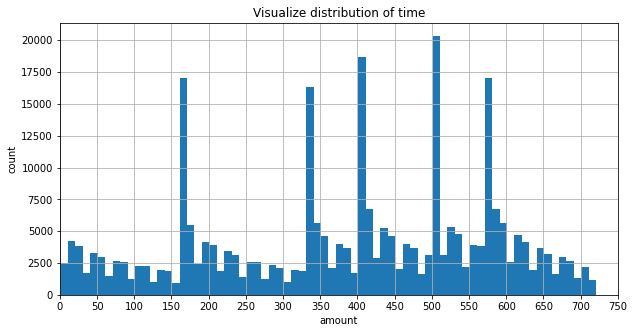

In [93]:
# Visualize distribution of amount:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]
bins = np.arange(1, transcript['amount'].max()+10, 10)

transcript.time.hist(bins = bins);
plt.title('Visualize distribution of time');
plt.ylabel('count');
plt.xlabel('amount');
tick = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750]
label = ['{}'.format(ele) for ele in tick]
plt.xticks(tick, label);
plt.xlim((0,750));

* ¿Cuál es la distribución de eventos en las transcripciones?
* ¿Cuál es el porcentaje de transacciones y ofertas en el evento?

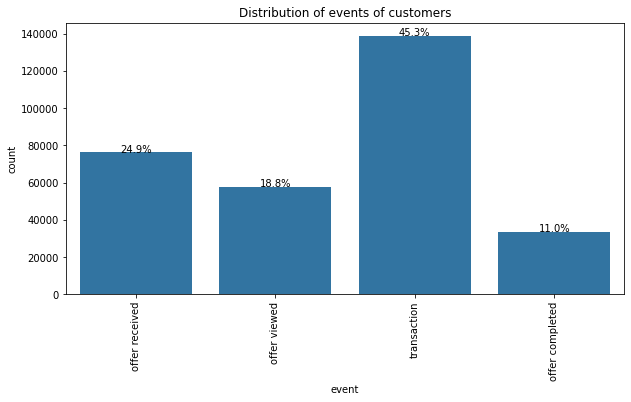

In [94]:
# Visualize distribution of events:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]

sb.countplot(data = transcript, x = 'event', color = color);
plt.title('Distribution of events of customers');
plt.ylabel('count');
plt.xlabel('event');

value_sum = transcript['event'].value_counts().sum()
value = transcript['event'].value_counts()

locs, labels = plt.xticks(rotation = 90) 

for loc, label in zip(locs, labels):

    count = value[label.get_text()]
    text = '{:0.1f}%'.format(100 * count/value_sum)

    plt.text(loc, count+2, text, ha = 'center', color = 'black');

* According to graph, We can see that most of the transcripts are transactions.
* Nearly 45.3% are transactions and 54.7% are offer

* ¿Cuál es la distribución de eventos en las transcripciones?
* ¿Cuál es el porcentaje de transacciones y ofertas en el evento?

In [95]:
new = transcript[transcript['event'] != 'transaction']
new = pd.DataFrame(new)
new.head()

,offer_completed,offer_recived,offer_viewed,transaction,customer_id,event,time,offer_id,amount,reward
0,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,NaN
1,0,1,0,0,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,NaN
2,0,1,0,0,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,NaN
3,0,1,0,0,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,NaN
4,0,1,0,0,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,NaN


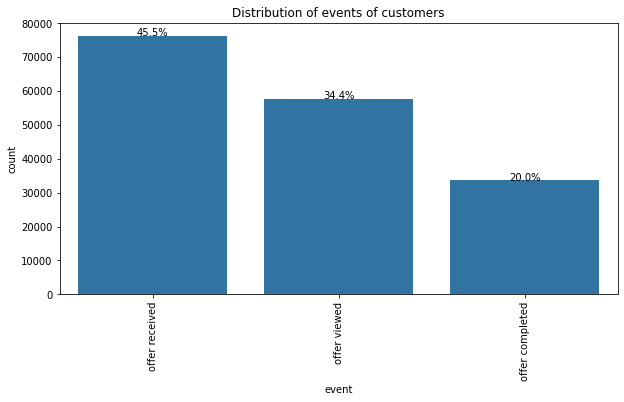

In [96]:
# Visualize distribution of events without transcations count:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]

sb.countplot(data = new, x = new['event'], color = color);
plt.title('Distribution of events of customers');
plt.ylabel('count');
plt.xlabel('event');

value_sum = new['event'].value_counts().sum()
value = new['event'].value_counts()
locs, labels = plt.xticks(rotation = 90) 

for loc, label in zip(locs, labels):

    count = value[label.get_text()]
    text = '{:0.1f}%'.format(100 * count/value_sum)

    plt.text(loc, count+2, text, ha = 'center', color = 'black');

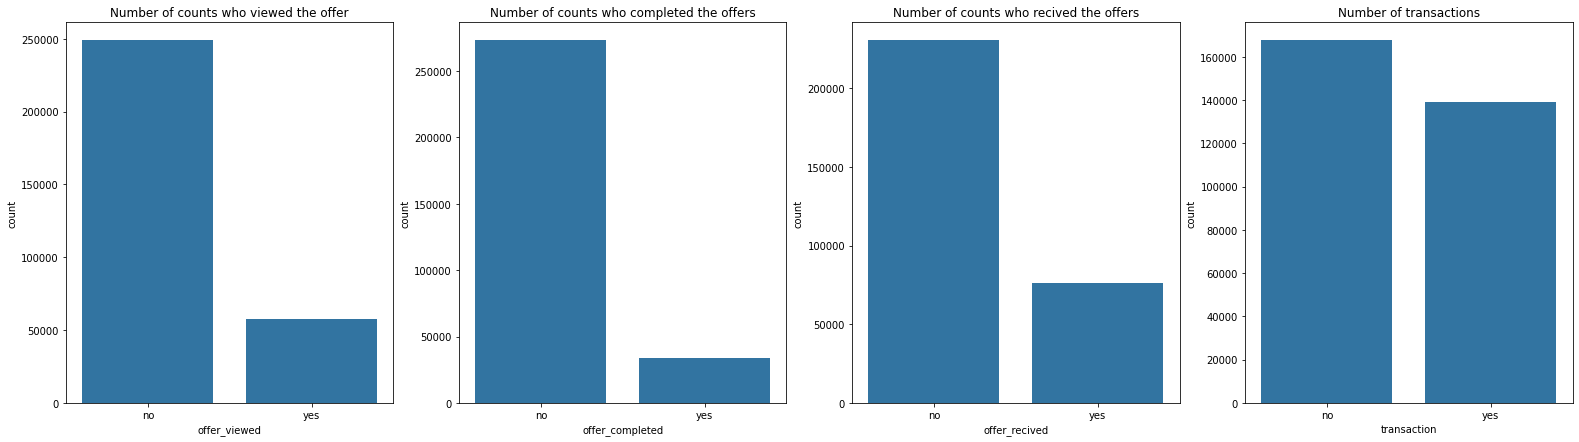

In [97]:
# Graph for Number of counts who recived, viewed, completed the offers:

plt.figure(figsize = [27,7])
color = sb.color_palette()[0]

plt.subplot(1,4,1)
x = sb.countplot(data = transcript, x = 'offer_viewed', color = color);
plt.title('Number of counts who viewed the offer');
plt.ylabel('count');
plt.xlabel('offer_viewed');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(1,4,2)
x = sb.countplot(data = transcript, x = 'offer_completed', color = color);
plt.title('Number of counts who completed the offers');
plt.ylabel('count');
plt.xlabel('offer_completed');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(1,4,3)
x = sb.countplot(data = transcript, x = 'offer_recived', color = color);
plt.title('Number of counts who recived the offers');
plt.ylabel('count');
plt.xlabel('offer_recived');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(1,4,4)
x = sb.countplot(data = transcript, x = 'transaction', color = color);
plt.title('Number of transactions');
plt.ylabel('count');
plt.xlabel('transaction');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

## Combine los tres conjuntos de datos con columnas comunes en uno para un análisis más detallado:

In [98]:
data = transcript.merge(profile, on = ['customer_id'])
transcript.shape, profile.shape, data.shape

((306534, 10), (14825, 12), (272762, 21))

In [99]:
data.shape

(272762, 21)

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   offer_completed        272762 non-null  uint8         
 1   offer_recived          272762 non-null  uint8         
 2   offer_viewed           272762 non-null  uint8         
 3   transaction            272762 non-null  uint8         
 4   customer_id            272762 non-null  object        
 5   event                  272762 non-null  object        
 6   time                   272762 non-null  int64         
 7   offer_id               148805 non-null  object        
 8   amount                 272762 non-null  float64       
 9   reward                 32444 non-null   float64       
 10  gender                 272762 non-null  object        
 11  age                    272762 non-null  int64         
 12  became_member_on       272762 non-null  date

In [101]:
new_data = data.merge(portfolio, on = ['offer_id'], how = 'left')
portfolio.shape, data.shape

((10, 10), (272762, 21))

* Después de fusionar los tres conjuntos de datos, el conjunto new_data final contiene 272762 filas y 30 columnas.

In [102]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   offer_completed        272762 non-null  uint8         
 1   offer_recived          272762 non-null  uint8         
 2   offer_viewed           272762 non-null  uint8         
 3   transaction            272762 non-null  uint8         
 4   customer_id            272762 non-null  object        
 5   event                  272762 non-null  object        
 6   time                   272762 non-null  int64         
 7   offer_id               148805 non-null  object        
 8   amount                 272762 non-null  float64       
 9   reward_x               32444 non-null   float64       
 10  gender                 272762 non-null  object        
 11  age                    272762 non-null  int64         
 12  became_member_on       272762 non-null  date

* Dataframe que consta de todos los datos relacionados con las ofertas se separa en (oferta_datos)
* Dataframe que consta de todos los datos relacionados con las transacciones se separa en (transaction_data).

In [103]:
transaction_df = new_data[new_data['event'] == 'transaction']
transaction_df.head()

,offer_completed,offer_recived,offer_viewed,transaction,customer_id,event,time,offer_id,amount,reward_x,...,member_since_year,reward_y,channels,difficulty,duration,offer_type,email,web,mobile,social
2,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,NaN,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,NaN,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,NaN,19.67,NaN,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,NaN,29.72,NaN,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,NaN,23.93,NaN,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
transaction_df.shape

(123957, 30)

In [105]:
offer_df = new_data[new_data['transaction'] != 1]
offer_df.head()

,offer_completed,offer_recived,offer_viewed,transaction,customer_id,event,time,offer_id,amount,reward_x,...,member_since_year,reward_y,channels,difficulty,duration,offer_type,email,web,mobile,social
0,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,NaN,...,5,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,0,0,1,0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,NaN,...,5,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,1.0,1.0,0.0
3,1,0,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,...,5,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,1.0,1.0,0.0
5,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.0,NaN,...,5,0.0,"[email, mobile, social]",0.0,3.0,informational,1.0,0.0,1.0,1.0
6,0,0,1,0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,0.0,NaN,...,5,0.0,"[email, mobile, social]",0.0,3.0,informational,1.0,0.0,1.0,1.0


In [106]:
print('mean time value: ', offer_df.time.mean())
print('median time value: ',offer_df.time.median())

mean time value:  354.57022277477233
median time value:  408.0


In [107]:
print('mean age value: ', offer_df.age.mean())
print('median age value: ',offer_df.age.median())
print('total age value: ', offer_df.age.sum())
print('maximum age value: ',offer_df.age.max())
print('minimum age value: ',offer_df.age.min())

mean age value:  54.77928161016095
median age value:  56.0
total age value:  8151431
maximum age value:  101
minimum age value:  18


In [108]:
offer_df.reset_index(inplace=True)
del offer_df['index']

In [109]:
offer_df.head()

,offer_completed,offer_recived,offer_viewed,transaction,customer_id,event,time,offer_id,amount,reward_x,...,member_since_year,reward_y,channels,difficulty,duration,offer_type,email,web,mobile,social
0,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,NaN,...,5,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,0,0,1,0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,NaN,...,5,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,1.0,1.0,0.0
2,1,0,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,...,5,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,1.0,1.0,0.0
3,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.0,NaN,...,5,0.0,"[email, mobile, social]",0.0,3.0,informational,1.0,0.0,1.0,1.0
4,0,0,1,0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,0.0,NaN,...,5,0.0,"[email, mobile, social]",0.0,3.0,informational,1.0,0.0,1.0,1.0


In [110]:
offer_df.drop(['channels', 'transaction', 'amount', 'reward_x'], axis = 1, inplace = True)

C:\Users\Oscar\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Data Labelling:

* Label las columnas - offer_id. offer_type, gender, and the unique customer_ids

In [111]:
from sklearn import preprocessing

# label encoding - offer_id (10 different IDs) from the portfolio data set:

le_1 = preprocessing.LabelEncoder()
le_1.fit(portfolio['offer_id'])

offer_df['offer_id'] = le_1.fit_transform(offer_df['offer_id'].astype(str))

C:\Users\Oscar\AppData\Local\Temp/ipykernel_14320/274976661.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_df['offer_id'] = le_1.fit_transform(offer_df['offer_id'].astype(str))


In [112]:
le_2 = preprocessing.LabelEncoder()
le_2.fit(portfolio.offer_type)

offer_df['offer_type'] = le_2.fit_transform(offer_df['offer_type'].astype(str))

C:\Users\Oscar\AppData\Local\Temp/ipykernel_14320/1096974987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_df['offer_type'] = le_2.fit_transform(offer_df['offer_type'].astype(str))


In [114]:
le_3 = preprocessing.LabelEncoder()
le_3.fit(profile['gender'])

offer_df['gender'] = le_3.fit_transform(offer_df['gender'].astype(str))

C:\Users\Oscar\AppData\Local\Temp/ipykernel_14320/2985021201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_df['gender'] = le_3.fit_transform(offer_df['gender'].astype(str))


In [115]:
# etiquete las identificaciones únicas de los clientes, cree una función de mapeo para evitar la duplicación:

def id_mapper():
    """
    INPUT: 
    col_name (str): name of the column whose values are to be changed
    
    OUTPUT:
    id_encoded (list): list of the mapped integers for each value
    
    Description:
    This function will map integers to such '912b9f623b9e4b4eb99b6dc919f09a93' long values.
    
    """
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in offer_df['customer_id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

id_encoded = id_mapper()
del offer_df['customer_id']
offer_df['customer_ids'] = id_encoded

# show header
offer_df.sample(5)

C:\Users\Oscar\AppData\Local\Temp/ipykernel_14320/572928138.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_df['customer_ids'] = id_encoded


,offer_completed,offer_recived,offer_viewed,event,time,offer_id,gender,age,became_member_on,income,...,member_since_year,reward_y,difficulty,duration,offer_type,email,web,mobile,social,customer_ids
117225,0,1,0,offer received,168,1,1,40,2018-06-01,32000.0,...,4,3.0,7.0,7.0,1,1.0,1.0,1.0,1.0,11087
146394,0,1,0,offer received,504,5,0,56,2017-12-12,74000.0,...,4,0.0,0.0,3.0,2,1.0,0.0,1.0,1.0,14455
5786,0,1,0,offer received,408,6,0,56,2016-06-24,55000.0,...,5,5.0,5.0,7.0,0,1.0,1.0,1.0,0.0,539
141374,0,0,1,offer viewed,606,9,1,74,2017-11-12,89000.0,...,4,2.0,10.0,10.0,1,1.0,1.0,1.0,1.0,13875
106923,0,1,0,offer received,168,5,1,41,2015-10-24,100000.0,...,6,0.0,0.0,3.0,2,1.0,0.0,1.0,1.0,10100


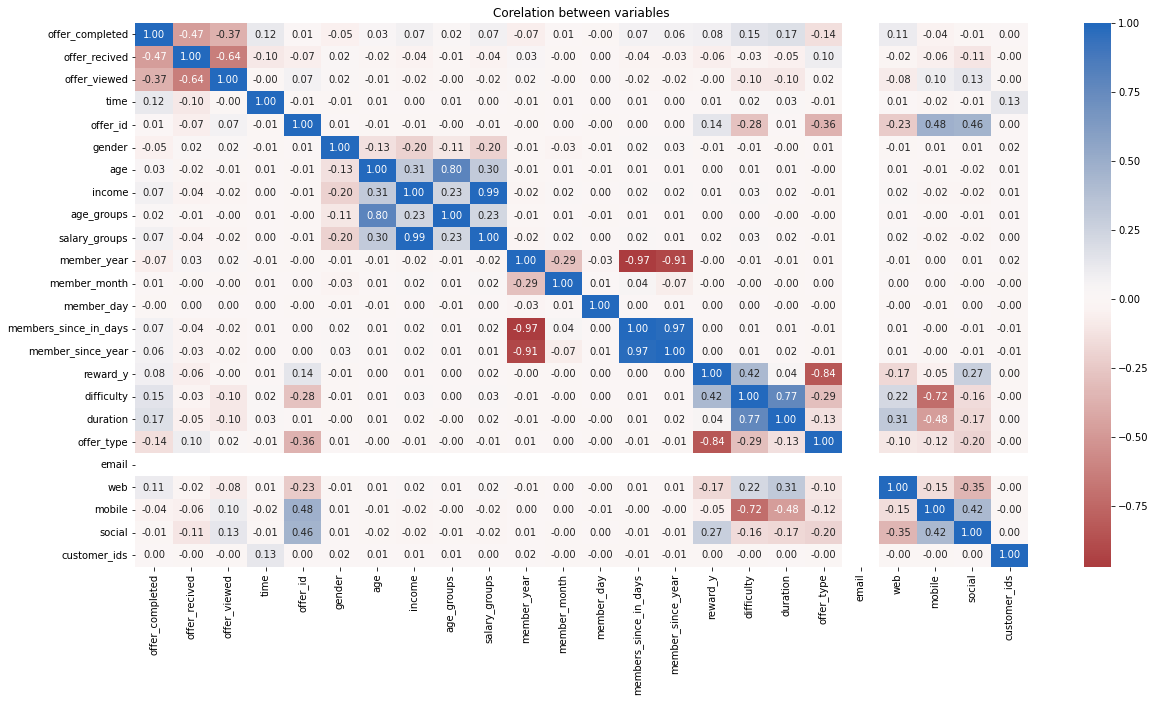

In [116]:
# heat map for cleaned dataset:

plt.figure(figsize = [20,10])

sb.heatmap(offer_df.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plt.title('Corelation between variables');

In [117]:
offer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148805 entries, 0 to 148804
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   offer_completed        148805 non-null  uint8         
 1   offer_recived          148805 non-null  uint8         
 2   offer_viewed           148805 non-null  uint8         
 3   event                  148805 non-null  object        
 4   time                   148805 non-null  int64         
 5   offer_id               148805 non-null  int32         
 6   gender                 148805 non-null  int32         
 7   age                    148805 non-null  int64         
 8   became_member_on       148805 non-null  datetime64[ns]
 9   income                 148805 non-null  float64       
 10  age_groups             148805 non-null  int64         
 11  salary_groups          148805 non-null  int64         
 12  member_year            148805 non-null  int6

## Exploratory Data Analysis for merged data (new_data) dataset:

* ¿Cuáles son los tipos de Oferta entre edades, sexos y grupos de ingresos?

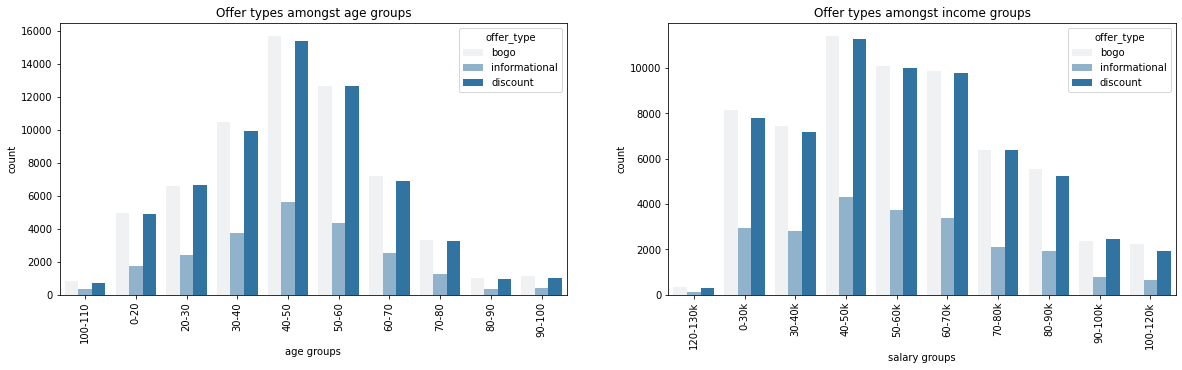

In [118]:
# Graph for Offer types amongst ages, salary groups:

plt.figure(figsize = [20,5])
color = sb.color_palette()[0]

plt.subplot(1,2,1)
x = sb.countplot(data = new_data, x = 'age_groups', hue = 'offer_type', color = color);
plt.title('Offer types amongst age groups');
plt.ylabel('count');
plt.xlabel('age groups');
xlabels = ['100-110', '0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,2,2)
x = sb.countplot(data = new_data, x = 'salary_groups', hue = 'offer_type', color = color);
plt.title('Offer types amongst income groups');
plt.ylabel('count');
plt.xlabel('salary groups');
xlabels = ['120-130k', '0-30k', '30-40k', '40-50k', '50-60k', '60-70k', '70-80k', '80-90k', '90-100k', '100-120k']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

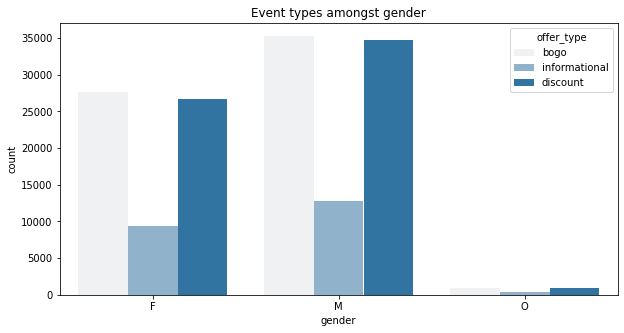

In [119]:
# Graph for event types amongst gender:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]

sb.countplot(data = new_data, x = 'gender', hue = 'offer_type', color = color);
plt.title('Event types amongst gender');
plt.ylabel('count');
plt.xlabel('gender');

#### Podemos ver en los gráficos anteriores que Bogo es un poco más popular entre los grupos de edad, género e ingresos.

El grupo de 40-50 años responde más a estas ofertas que los otros grupos

Además, para income distribution, la oferta informativa ronda casi el 50% que las otras dos.

La mayoría de los hombres son encuestados de estas ofertas que las mujeres con BOGO como su tipo principal

En resumen, los clientes activos de Starbucks que respondieron pertenecen al grupo de edad de 40 a 50 años, con un mayor porcentaje de hombres que tienen un ingreso anual de 40 a 50 mil.

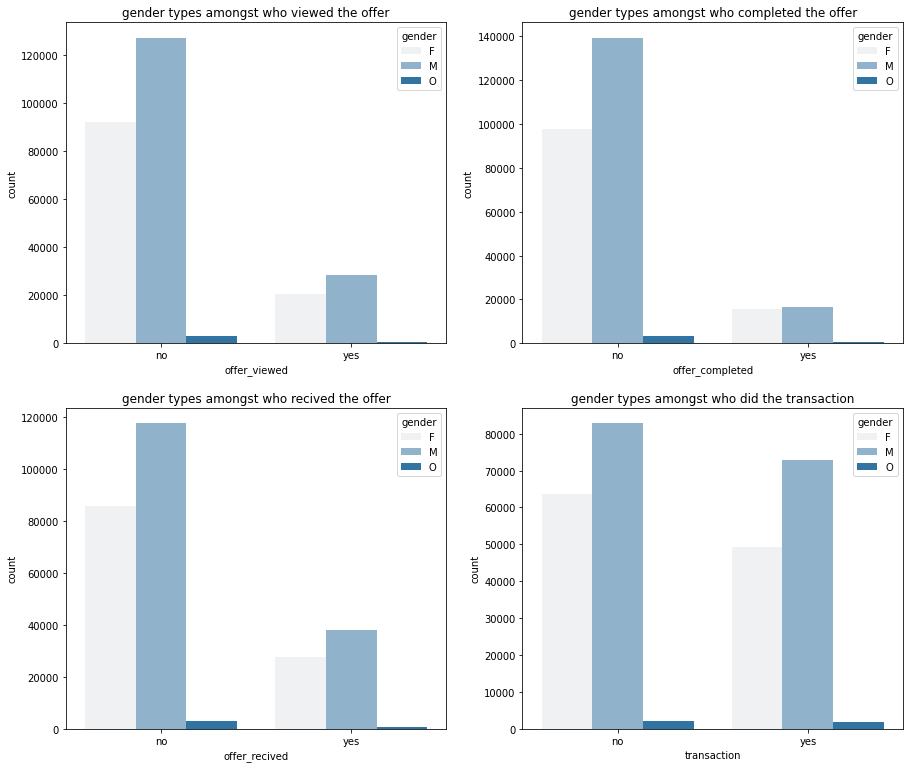

In [120]:
# Graph for gender amongst event types:

plt.subplots(2, 2, figsize=(15, 13))
color = sb.color_palette()[0]

plt.subplot(2,2,1)
x = sb.countplot(data = new_data, x = 'offer_viewed', hue = 'gender', color = color);
plt.title('gender types amongst who viewed the offer');
plt.ylabel('count');
plt.xlabel('offer_viewed');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(2,2,2)
x = sb.countplot(data = new_data, x = 'offer_completed', hue = 'gender', color = color);
plt.title('gender types amongst who completed the offer');
plt.ylabel('count');
plt.xlabel('offer_completed');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(2,2,3)
x = sb.countplot(data = new_data, x = 'offer_recived', hue = 'gender', color = color);
plt.title('gender types amongst who recived the offer');
plt.ylabel('count');
plt.xlabel('offer_recived');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(2,2,4)
x = sb.countplot(data = new_data, x = 'transaction', hue = 'gender', color = color);
plt.title('gender types amongst who did the transaction');
plt.ylabel('count');
plt.xlabel('transaction');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

In [122]:
offer_df.head()

,offer_completed,offer_recived,offer_viewed,event,time,offer_id,gender,age,became_member_on,income,...,member_since_year,reward_y,difficulty,duration,offer_type,email,web,mobile,social,customer_ids
0,0,1,0,offer received,0,6,0,75,2017-05-09,100000.0,...,5,5.0,5.0,7.0,0,1.0,1.0,1.0,0.0,1
1,0,0,1,offer viewed,6,6,0,75,2017-05-09,100000.0,...,5,5.0,5.0,7.0,0,1.0,1.0,1.0,0.0,1
2,1,0,0,offer completed,132,6,0,75,2017-05-09,100000.0,...,5,5.0,5.0,7.0,0,1.0,1.0,1.0,0.0,1
3,0,1,0,offer received,168,5,0,75,2017-05-09,100000.0,...,5,0.0,0.0,3.0,2,1.0,0.0,1.0,1.0,1
4,0,0,1,offer viewed,216,5,0,75,2017-05-09,100000.0,...,5,0.0,0.0,3.0,2,1.0,0.0,1.0,1.0,1
